<a href="https://colab.research.google.com/github/DGkurnia/sentiment/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Nama: Derfansyah Guswiranata Kurnia
* Identitas Dicoding : dgkurnia
* email dicoding : weerakurnia@gmail.com
* Alamat: Jalan Malaka Hijau No 39 Perumahan Malaka Country Estate Jakarta Timur

#Pembaruan

In [1]:
#request dan pandas
!pip install requests pandas

In [2]:
#instalasi sastarawi
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.2 MB/s eta 0:00:00


In [3]:
#instalasi wordcloud
!pip install wordcloud

In [4]:
#instalasi XGBOOSTER
!pip install xgboost

In [5]:
#instalasi backoff
!pip install backoff aiohttp

In [6]:
#instalasi S-BERT
!pip install sentence-transformers

# Impor Perpustakaan

In [7]:
#untuk akses ke google drive (bila diperlukan)
from google.colab import drive
drive.mount('/content/drive')
#impor file lokal
from google.colab import files

Mounted at /content/drive


In [8]:
#instalasi perpustakaan
import requests
import json
#Bagian Pandas
import pandas as pd
pd.options.mode.chained_assignment = None #pengaturan peringatan 'rantai'
import csv
import string
#ke manajemen

In [9]:
#manajemen data dasar
import numpy as np
seed = 0 #reprodubilitas
np.random.seed(seed)
#ke plt

In [10]:
#Bagian plt
import matplotlib.pyplot as plt
import datetime as dt #jika ada tanggal
#perpustakaan untuk interpolasi
from scipy.interpolate import interp1d
#waktu
import time
#ke sastawi, NLTK, dan wordcloud

In [11]:
#Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory #bagian 'stemmer factory'
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [12]:
#sastrawi dan NITK [NITK]
import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt_tab')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
from nltk.corpus import stopwords  # Mengimpor modul stopwords dari pustaka NLTK.
from nltk.tokenize import word_tokenize  # Mengimpor fungsi word_tokenize dari modul tokenize dalam pustaka NLTK.

#impor wordcloud
from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks
#ke sastrawi

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
#multiprocessing
import warnings #peringatan
import multiprocessing as mp #untuk multiprocessing
from multiprocessing import Pool
import joblib #Bagian Joblib
#berat data
from sklearn.utils.class_weight import compute_sample_weight as csw #inspeksi berat dulu

### Impor Teknik

In [14]:
#pemisahan data dengan 'train test split' dan bernouli
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import BernoulliNB

In [15]:
#pelabelan
from sklearn.preprocessing import LabelEncoder

In [16]:
#Teknik untuk inspeksi: perpustakaan untuk klasifikasi
from sklearn.ensemble import RandomForestClassifier as rfclasifi #teknik 'randomfprest'
from sklearn.tree import DecisionTreeClassifier #teknik 'keputusan'
from sklearn.svm import SVC #teknik SVC
from sklearn.linear_model import LogisticRegression

In [17]:
#teknik tmodel gensim
from sklearn.model_selection import learning_curve as lencur #Kurva pemberlajaran

In [18]:
#Bagian re IO bentuk string
import re
from io import StringIO
#modifikais SMOTE
from imblearn.over_sampling import SMOTE
#Transformasi kata
from gensim.models import FastText

In [19]:
#metrik penilaian (akurasi, lenyap/loss, nilai f1, nilai recall)
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
#metrik
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix as cmatrix, ConfusionMatrixDisplay as cmatdisp, classification_report as clsfrep
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
#laporan klasifikasi
from sklearn.datasets import make_classification

In [20]:
#impor seaborn dkk
import seaborn as sns
#vekrtorisasi
from sklearn.feature_extraction.text import TfidfVectorizer #Tfid
from sklearn.feature_extraction.text import CountVectorizer #Count
#peta SVM
from sklearn.datasets import load_breast_cancer

In [21]:
#Teknik SVM dengan XGBOOST
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

#Persiapan Ekstraksi situs

##Pendaftaran situs

In [22]:
#deklarasi 'URL target' dan asal URL
turldoma = 'https://gql.tokopedia.com/graphql/productReviewList'
asal = 'https://www.tokopedia.com' #semua dari Tokopedia
#ke pendaftaran URL

In [23]:
"""
#Daftar 'URL referensi' dan 'cookie' di Tokopedia
#daftar URL referensi (dinaikan jadi 21)
"""
uploaded = files.upload()
nmfil0 = "situs.txt"
urllist = []
#ke pebukaan file untuk situs
#pembukaan file
with open(nmfil0, 'r') as f:
    urllist = [line.strip() for line in f.readlines()]  # Pembacaan garis
#cetak bentuk akhir
#print(urllist) #cek bentuk dahulu
print(len(urllist))

Saving situs.txt to situs.txt
22


In [24]:
#pendaftaran cookie (dari atas ke bawah: a,b,c,d,e,f,g,h,i,j,k,l,m,n)
uploaded = files.upload()
nmfil0b = "cookie.txt"
cooklist = []
#pembukaan file
with open(nmfil0b, 'r') as f:
    cooklist = [line.strip() for line in f.readlines()]  # Pembacaan garis
#cetak bentuk akhir
print(len(cooklist))  # bentuk Jadi

Saving cookie.txt to cookie.txt
22


In [25]:
#persiapan 'identitas produk'
idlist =  ["7576252307", "1624334615", "7576433902",  "1624293521",  "1624323568",  "2390937942" ,"1624205892", "1850455319","1631510531","1822516139",
           "1624428906", "7576024423", "7876362065", "1624265285", "1764737976", "1624357196","1624417776","1624322866",
           "7877584454", "1624392272","1624297447","7878113218"] #sebelas sampel ini dari Erigo
#ke fragmentasi

urutan identitas produk dari kiri ke kanan : [a , b , c , d , e, f ,g ,h, i , j ,k , l, m, n , o , p, q, r, s, t, u, v]

In [26]:
#fragmentasi data untuk kemudahan
[urla, urlb, urlc, urld, urle, urlf, urlg, urlh, urli, urlj, urlk, urll, urlm, urln, urlo, urlp, urlq, urlr, urls, urlt, urlu, urlv] = urllist #daftar URL referensi
"""
#[cookiea, cookieb, cookiec, cookied, cookiee, cookief, cookieg, cookieh, cookiei, cookiej, cookiek, cookiel, cookiem, cookiem, cookien, cookieo, cookiep, cookieq, cookier, cookies, cookiet, cookieu, cookiev] = cooklist #daftar cookie
"""
[ida, idb, idc, idd, ide, idf, idg, idh, idi, idj, idk, idl, idm, idn,ido, idp, idq, idr, ids, idt, idu, idv] = idlist #daftar ID produk
#ke persiapan target dan kepala

# Proses Iterasi untuk data

## Persiapan

### Pembentukan kepala dan **'bentuk kueri'**

In [27]:
#Persiapan kepala dan kueri yang distandardisasi
def stdheader(url, idpr): #idpr adalah identitas produk
  halaman_awal = 1 #di kueri
  kplstd = {'accept': '*/*',
   'accept-language': 'en-US,en;q=0.9',
   'content-type': 'application/json',
   'dnt': '1' ,
   'origin': asal,
   'priority': 'u=1, i',
   'referer': url,
   'sec-ch-ua': '"Not A(Brand";v="8", "Chromium";v="132", "Google Chrome";v="132"',
   'sec-ch-ua-mobile': '?0',
   'sec-ch-ua-platform': '"Windows"',
   'sec-fetch-dest': 'empty',
   'sec-fetch-mode': 'cors',
   'sec-fetch-site': 'same-site',
   'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36',
   'x-price-center': 'true',
   'x-source': 'tokopedia-lite',
   'x-tkpd-lite-service': 'zeus',
   'x-version': '1c2c0dd'}
  return kplstd

In [28]:
#variasi kepala untuk iterasi [dari indeks 0 ke lima dengan arah kiri ke kanan]
kplstdlist = [stdheader(urla, ida), stdheader(urlb, idb), stdheader(urlc, idc), stdheader(urld, idd), stdheader(urle, ide),
              stdheader(urlf, idf), stdheader(urlg, idg), stdheader(urlh, idh), stdheader(urli, idi), stdheader(urlj, idj),
              stdheader(urlk, idk), stdheader(urll, idl), stdheader(urlm, idm), stdheader(urln, idn), stdheader(urlo,ido),
              stdheader(urlp,idp), stdheader(urlq,idq), stdheader(urlr,idr), stdheader(urls,ids), stdheader(urlt,idt), stdheader(urlu,idu), stdheader(urlv,idv)]
#ke persiapan bentuk melalui iterasi

### Iterasi utama untuk menghasilkan data

In [29]:
# Proses iterasi produk
def datagenerator(url, idpr):
    # Pemanggilan fungsi pertama (stdheader)
    header = stdheader(url, idpr)
    # Persiapan bentuk untuk iterasi
    daftar_teks = []
    daftar_nilai = []
    daftar_label = []

    # Batas halaman untuk ulasan
    awal = 1  # dari halaman 1
    akhir = 50  # batas ulasan paling tinggi

    # Iterasi
    while awal <= akhir:
        # Pemformatan kueri
        fquery = f'[{{"operationName":"productReviewList","variables":{{"productID":"{idpr}","page":{awal},"limit":10,"sortBy":"informative_score desc","filterBy":""}},"query":"query productReviewList($productID: String\u0021, $page: Int\u0021, $limit: Int\u0021, $sortBy: String, $filterBy: String) {{\\n  productrevGetProductReviewList(productID: $productID, page: $page, limit: $limit, sortBy: $sortBy, filterBy: $filterBy) {{\\n    productID\\n    list {{\\n      id: feedbackID\\n      variantName\\n      message\\n      productRating\\n      reviewCreateTime\\n      reviewCreateTimestamp\\n      isReportable\\n      isAnonymous\\n      imageAttachments {{\\n        attachmentID\\n        imageThumbnailUrl\\n        imageUrl\\n        __typename\\n      }}\\n      videoAttachments {{\\n        attachmentID\\n        videoUrl\\n        __typename\\n      }}\\n      reviewResponse {{\\n        message\\n        createTime\\n        __typename\\n      }}\\n      user {{\\n        userID\\n        fullName\\n        image\\n        url\\n        __typename\\n      }}\\n      likeDislike {{\\n        totalLike\\n        likeStatus\\n        __typename\\n      }}\\n      stats {{\\n        key\\n        formatted\\n        count\\n        __typename\\n      }}\\n      badRatingReasonFmt\\n      __typename\\n    }}\\n    shop {{\\n      shopID\\n      name\\n      url\\n      image\\n      __typename\\n    }}\\n    hasNext\\n    totalReviews\\n    __typename\\n  }}\\n}}\\n"}}]'

        # Make request
        response = requests.post(turldoma, headers=header, data=fquery)

        # Check for HTTP errors
        if response.status_code != 200:
            print(f"Error: Received status code {response.status_code}")
            break

        try:
            daftar_ulasan = response.json()[0]['data']['productrevGetProductReviewList']['list']
            if not daftar_ulasan:
                break  # Exit loop if no reviews are returned

            for review in daftar_ulasan:
              daftar_teks.append(review['message'])
              daftar_nilai.append(review['productRating'])
              if review['productRating'] == 0:
                  daftar_label.append('total disappointment') #hal yang mengecewakan sekali
              elif review['productRating'] == 1:
                  daftar_label.append('so inferior') #hal sangat inferior
              elif review['productRating'] == 2:
                  daftar_label.append('very low') #sangat rendah
              elif review['productRating'] == 3:
                  daftar_label.append('average') #rata-rata
              elif review['productRating'] == 4:
                  daftar_label.append('good') #sangat bagus
              elif review['productRating'] == 5:
                  daftar_label.append('excelent') #sempurna
              else:
                  daftar_label.append('No score') #tak mau diulas
            awal += 1


        except (KeyError, IndexError) as e:
            print(f"Error parsing JSON response: {e}")
            break

    return daftar_teks, daftar_nilai, daftar_label
#ke eksekusi

In [30]:
#Proses pembentukan daftar dari enam produk untuk disatukan (Bagian 1)
teks1, nilai1, label1 = datagenerator(urla, ida) #ProdukA
teks2, nilai2, label2 = datagenerator(urlb, idb) #ProdukB
teks3, nilai3, label3 = datagenerator(urlc, idc) #ProdukC
teks4, nilai4, label4 = datagenerator(urld, idd) #Produk D
#ke bagian 2

In [31]:
#Bagian 2
teks5, nilai5, label5 = datagenerator(urle, ide) #Produk E
teks6, nilai6, label6 = datagenerator(urlf,idf) #produk F
teks7, nilai7, label7 = datagenerator(urlg,idg) #produk G
teks8, nilai8, label8 = datagenerator(urlh,idh) #produk H
#ke bagian 3

In [32]:
#Bagian 3
teks9, nilai9, label9 = datagenerator(urli,idi) #produk I
teks10, nilai10, label10 = datagenerator(urlj,idj) #produk J
teks11, nilai11, label11 = datagenerator(urlk,idk) #produk K
teks12, nilai12, label12 = datagenerator(urll,idl) #produk L
#ke bagian 4

In [33]:
#Bagian 4
teks13, nilai13, label13 = datagenerator(urlm,idm) #produk M
teks14, nilai14, label14 = datagenerator(urln,idn) #produk N
teks15, nilai15, label15 = datagenerator(urlo,ido) #produk 0
teks16, nilai16, label16 = datagenerator(urlp,idp) #produk P

In [34]:
#Bagian 5
teks17, nilai17, label17 = datagenerator(urlq,idq) #produk Q
teks18, nilai18, label18 = datagenerator(urlr,idr) #produk R
teks19, nilai19, label19 = datagenerator(urls,ids) #produk S
teks20, nilai20, label20 = datagenerator(urlt,idt) #produk T

In [35]:
#Bagian 6
teks21, nilai21, label21 = datagenerator(urlu,idu) #produk U
teks22, nilai22, label22 = datagenerator(urlv,idv) #produk V

### Penyatuan ke satu data

In [36]:
#Penyatuan tahap 1 (data teks baju dan celana)
teksba = teks1 + teks2 + teks3 + teks4 + teks5 + teks6 + teks7 + teks8 + teks9 #dari baju
tekscel = teks10 + teks11 + teks12 + teks13 + teks14 + teks15 + teks16 + teks17+ teks18+ teks19 + teks20 + teks21 + teks22 #dari celana
#bagian nilai
nilba = nilai1 + nilai2 + nilai3 + nilai4 + nilai5 + nilai6 + nilai7 + nilai8 + nilai9 #Baju
nilcel = nilai10 + nilai11 + nilai12 + nilai13 + nilai14 + nilai15 + nilai16 + nilai17 + nilai18 + nilai19 + nilai20 + nilai21 + nilai22 #Celana
#Bagian label
labeba = label1 + label2 + label3 + label4 + label5 + label6 + label7 + label8 + label9
labecel = label10 + label11 + label12 + label13 + label14 + label15 + label16 + label17 + label18 + label19 + label20 + label21 + label22

In [37]:
#deklarasi total ulasan
sampteks = teksba + tekscel #bagian teks
sampnilai = nilba + nilcel #bagian nilai
samplabel = labeba + labecel #bagian label
#ke konversi ke df

semua ulasan ini berasal dari enam produk berasal dari Erigo

In [38]:
#penyatuan ke dataframe
dfori = pd.DataFrame({'Pesan': sampteks,'Nilai': sampnilai,'Label': samplabel},copy=True)
dfkopi = dfori.copy()
#cek panjang
lendfkop = len(dfkopi)
print(lendfkop)

9582


#### Inspeksi hasil data dari kesalahan

In [39]:
#cek sampel data
kepdfkopi = dfkopi.head(7)
kepdfkopi

,Pesan,Nilai,Label
0,barang bagus kualitas nya top harga nya naik o...,5,excelent
1,"modelnya keren, bahannya bagus cuma agak kepan...",5,excelent
2,"tinggi 175 bb 60 ukuran L cocok si, pas dan en...",5,excelent
3,enak di pake adem dan kece pas di badan gw. ta...,5,excelent
4,APAAN INI WOY KEREN BANGET KEMEJA NYA ga usa r...,5,excelent
5,"oke paket di terima dengan baik ,, untuk kuali...",5,excelent
6,"pas, bahannya enak banget dibadan dan juga ker...",5,excelent


In [40]:
#cek kolom
dfkopinfo = dfkopi.info()
print(dfkopinfo)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pesan   9582 non-null   object
 1   Nilai   9582 non-null   int64 
 2   Label   9582 non-null   object
dtypes: int64(1), object(2)
memory usage: 224.7+ KB
None


#### Pembersihan data (bebas dari data duplikat dan kosong)

In [41]:
#Data Kosong
totkos = dfkopi.isnull().sum() #Kosong
totkos

,0
Pesan,0
Nilai,0
Label,0


In [42]:
#inspeksi data hilang
tothil = dfkopi.isna().sum() #Hilang
print(tothil)

Pesan    0
Nilai    0
Label    0
dtype: int64


In [43]:
#inspeksi data duplikat
dfkopi.duplicated().sum()

1568

In [44]:
#Pembersihan data duplikat
dfkopi.drop_duplicates(inplace=True)
dfkopitung = dfkopi.copy()
kep2 = dfkopitung.head(7) #pasca pembersihan
print(kep2)

                                               Pesan  Nilai     Label
0  barang bagus kualitas nya top harga nya naik o...      5  excelent
1  modelnya keren, bahannya bagus cuma agak kepan...      5  excelent
2  tinggi 175 bb 60 ukuran L cocok si, pas dan en...      5  excelent
3  enak di pake adem dan kece pas di badan gw. ta...      5  excelent
4  APAAN INI WOY KEREN BANGET KEMEJA NYA ga usa r...      5  excelent
5  oke paket di terima dengan baik ,, untuk kuali...      5  excelent
6  pas, bahannya enak banget dibadan dan juga ker...      5  excelent


In [45]:
#cek panjang
lendfkop2 = len(dfkopitung)
print(lendfkop2)

8014


#### Inspeksi kolom dan baris di hasil tunggal

In [46]:
#inspeksi
bntkdf = dfkopitung.shape
bntkdf

(8014, 3)

# Persiapan tahapan ulasan

## Penataan ulang kata-kata

### Kata Gaul

In [47]:
#Deklarasi kata-kata gaul
uploaded = files.upload()
nmfila = "kata.txt"
kata_gaul = []
#penulisan kata-kata gaul
with open(nmfila, 'r') as f:
    kata_gaul = [line.strip() for line in f.readlines()]  # Pembacaan garis
#cetak bentuk akhir
#print(kata_gaul)  # bentuk Jadi

Saving kata.txt to kata.txt


### Kamus Gaul

In [48]:
#Deklarasi kamus gaul
uploaded = files.upload()
nmfilb = "kamus.txt"
kamus_gaul = {}
#Penulisan kamus
with open(nmfilb, 'r') as f:
  for line in f:
    parts = line.strip().split(':', 1)  # Pembagian batas
    if len(parts) == 2:  # Hanya dua komponen
        kunci, nilai = parts
        kamus_gaul[kunci] = nilai
#cetak penataan ulang
#print(kamus_gaul)

Saving kamus.txt to kamus.txt


## Tahapan evaluasi kata-kata ke nilai

### Tahap Awal

In [49]:
#Kumpulan fungsi tahap 1 [Pembersihan dan penyeragaman]
def textcleaner (text): #Tahap 1
   text = re.sub(r'@[A-Za-z0-9]+', '', text) #penghilangan tanda at
   text = re.sub(r'#[A-Za-z0-9]+', '', text) #penghilangan tanda pagar
   text = re.sub(r'RT[\s]', '', text) #Bagian RE
   text = re.sub(r"http\S+", '', text) #Bagian penetralan HTTP
   text = re.sub(r'[0-9]+', '', text)
   text = re.sub(r'[^\w\s]', '', text)

   text = text.replace('\n', ' ')
   text = text.translate(str.maketrans('', '', string.punctuation))
   text = text.strip(' ')
   return text
#konversi ke huruf kecil dan 'tokenisasi'
def casefoldingText(text): # Konversi ke kata kecil
    text = text.lower()
    return text

def tokenizingText(text): # Tokenisasi
    text = word_tokenize(text)
    return text
#ke penyaringan

In [50]:
#penyaringan dan 'stemming' penyaringan
def textfilter(text):
    listStopwordsid = set(stopwords.words('indonesian'))
    listStopwordsen = set(stopwords.words('english'))
    listStopwordsid.update(listStopwordsen) #untuk ingris
    listStopwordsid.update(kata_gaul)
    filtrat = []
    for txt in text:
        if txt not in listStopwordsid:
            filtrat.append(txt)
    text = filtrat
    return text
#tahap steming
def textstemmer(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()


    words = text.split()


    stemmed_words = [stemmer.stem(word) for word in words]


    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def sentencerer(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [51]:
#manajemen kata-kata gaul
def slangfixer(text): #tolong pakai etika ya
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in kamus_gaul:
            fixed_words.append(kamus_gaul[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

### Persiapan filtrasi dari kolom pesan

In [52]:
#pengambilan kolom pesan
isipes = dfkopitung['Pesan'].copy() #cek pesan
nomor = dfkopitung['Nilai'].copy() #cek nilai
kategori = dfkopitung['Label'].copy() #cek Label

In [53]:
#Eksekusi masing-masing fungsi
dfkopitungk = dfkopitung.copy() #Jangan pakai data asli
#pelaksanaan fungsi [pembersihan teks]
dfkopitungk['bersih'] = isipes.apply(textcleaner)
#pemerataan
dfkopitungk['kecil'] = dfkopitungk['bersih'].apply(casefoldingText)
#pemformalan kata
dfkopitungk['sopan'] = dfkopitungk['kecil'].apply(slangfixer) #pakai etika
#ke tahapan selanjutnya

In [54]:
#tahapan selanjutmya
#pengambilan sampel ke 'tokenisasi'
dfkopitungk['token'] = dfkopitungk['sopan'].apply(tokenizingText) #tokenisasi
#penyaringan
dfkopitungk['stopword'] = dfkopitungk['token'].apply(textfilter)
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
dfkopitungk['final'] = dfkopitungk['token'].apply(sentencerer)

In [55]:
#cek bentuk akhir
kplmk3 = dfkopitungk.head(7)
kplmk3

,Pesan,Nilai,Label,bersih,kecil,sopan,token,stopword,final
0,barang bagus kualitas nya top harga nya naik o...,5,excelent,barang bagus kualitas nya top harga nya naik o...,barang bagus kualitas nya top harga nya naik o...,barang bagus kualitas nya top harga nya naik o...,"[barang, bagus, kualitas, nya, top, harga, nya...","[top, overall, dijamin, ori]",barang bagus kualitas nya top harga nya naik o...
1,"modelnya keren, bahannya bagus cuma agak kepan...",5,excelent,modelnya keren bahannya bagus cuma agak kepanj...,modelnya keren bahannya bagus cuma agak kepanj...,modelnya keren bahannya bagus cuma agak kepanj...,"[modelnya, keren, bahannya, bagus, cuma, agak,...","[modelnya, bahannya, kepanjangan, dipermak]",modelnya keren bahannya bagus cuma agak kepanj...
2,"tinggi 175 bb 60 ukuran L cocok si, pas dan en...",5,excelent,tinggi bb ukuran L cocok si pas dan enak ban...,tinggi bb ukuran l cocok si pas dan enak ban...,tinggi bb ukuran l cocok si pas dan enak bange...,"[tinggi, bb, ukuran, l, cocok, si, pas, dan, e...","[bb, ukuran, cocok, bahannya]",tinggi bb ukuran l cocok si pas dan enak bange...
3,enak di pake adem dan kece pas di badan gw. ta...,5,excelent,enak di pake adem dan kece pas di badan gw tap...,enak di pake adem dan kece pas di badan gw tap...,enak di pakai adem dan kece pas di badan say...,"[enak, di, pakai, adem, dan, kece, pas, di, ba...","[kayaknya, dipakai, modelnya, jahitannya, ukur...",enak di pakai adem dan kece pas di badan saya ...
4,APAAN INI WOY KEREN BANGET KEMEJA NYA ga usa r...,5,excelent,APAAN INI WOY KEREN BANGET KEMEJA NYA ga usa r...,apaan ini woy keren banget kemeja nya ga usa r...,apa ini woy keren banget kemeja nya tidak us...,"[apa, ini, woy, keren, banget, kemeja, nya, ti...","[usa, erigo, gmn, yah, erigo, pertahankan, udh...",apa ini woy keren banget kemeja nya tidak usa ...
5,"oke paket di terima dengan baik ,, untuk kuali...",5,excelent,oke paket di terima dengan baik untuk kualita...,oke paket di terima dengan baik untuk kualita...,oke paket di terima dengan baik untuk kualitas...,"[oke, paket, di, terima, dengan, baik, untuk, ...","[sayang, pengiriman]",oke paket di terima dengan baik untuk kualitas...
6,"pas, bahannya enak banget dibadan dan juga ker...",5,excelent,pas bahannya enak banget dibadan dan juga kere...,pas bahannya enak banget dibadan dan juga kere...,pas bahannya enak banget dibadan dan juga kere...,"[pas, bahannya, enak, banget, dibadan, dan, ju...","[bahannya, dibadan, erigo]",pas bahannya enak banget dibadan dan juga kere...


#Tahap eksekusi

## Tahap 'penerapan lexicon'

#### Deklarasi Lexicon

In [56]:
#Tahap awal fungsi lexicon (positif kiri negatif kanan)
[urlexp, urlexz, urlexn ]= ['https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv', 'https://raw.githubusercontent.com/cjhutto/vaderSentiment/master/vaderSentiment/vader_lexicon.txt', 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv']
#ke fungsi inspeksi lexicon

In [57]:
#tambahan
adisi1 = 'https://github.com/fajri91/InSet/blob/master/positive.tsv'
adisi2 = 'https://github.com/fajri91/InSet/blob/master/negative.tsv'

In [58]:
#URL ke emoji
emourl = 'https://raw.githubusercontent.com/today-is-a-good-day/emojis/refs/heads/master/emDict.csv'

#### Pembuatan lexicon

In [59]:
#lexicon positif di situs 1
plexicon = dict()
#pembutan respon
responp = requests.get(urlexp) #malas menulis lagi
if responp.status_code == 200:
    # Saat berhasil
    plreader = csv.reader(StringIO(responp.text), delimiter=',')
    # Jika Koma

    for row in plreader:
        # Mengulangi setiap baris dalam file CSV
        plexicon[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Data Lexicon Positif gagal diulas")

In [60]:
#lexicon di situs 2
zlexicon = dict()

# Fetch neutral lexicon data
responz = requests.get(urlexz)  # Link URL di atas
if responz.status_code == 200:  # variabel
    # Saat berhasil
    zlreader = csv.reader(StringIO(responz.text), delimiter='\t')
    next(zlreader)  # Skip the header row if it exists

    for row in zlreader:
        # Inspeksi batas
        if len(row) >= 2:
            try:
                # Check for empty strings and handle them gracefully
                if row[0].strip() != '':
                  zlexicon[row[0].strip()] = float(row[1].strip())  # Assuming the score is a float
            except ValueError as e:
                # Handle any rows with invalid data, such as scores that can't be converted to float
                print(f"Error: Invalid data in row: {row}. Skipping...")

else:
    print("Data Lexicon Netral gagal diulas")

In [61]:
#lexicon situs 3
nlexicon = dict()
#respon negatif [geez]
responsn = requests.get(urlexn)
if responsn.status_code == 200:
    # Saat berhasil
    negreader = csv.reader(StringIO(responsn.text), delimiter=',')
    #iterasi reader
    for row in negreader:
        # Mengulangi setiap baris dalam file CSV
        nlexicon[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya ke dalam kamus lexicon_negative
else:
    print("Data Lexicon Negatif gagal diulas")

In [62]:
# Adisi lexicon 1
zlexicon2 = dict()

# Fetch neutral lexicon data
responz2 = requests.get(adisi1)  # Link URL di atas
if responz.status_code == 200:  # Check if the request was successful
    # If successful, read the content
    zlreader2 = csv.reader(StringIO(responz2.text), delimiter='\t')  # Pakai tab
    next(zlreader2)  # Skip the header row if it exists

    for row in zlreader2:
        # Inspect boundaries
        if len(row) >= 2:
            try:
                # Check for empty strings and handle them gracefully
                if row[0].strip() != '':
                    zlexicon2[row[0].strip()] = float(row[1].strip())  # Assuming the score is a float
            except ValueError as e:
                # Handle any rows with invalid data, such as scores that can't be converted to float
                print(f"Error: Invalid data in row: {row}. Skipping...")
else:
    print("Data Lexicon Netral gagal diulas")

In [63]:
#adisi2
plexicon2 = dict()

# Fetch neutral lexicon data
responp2 = requests.get(adisi2)  # Link URL di atas
if responz.status_code == 200:  # Check if the request was successful
    # If successful, read the content
    plreader2 = csv.reader(StringIO(responp2.text), delimiter='\t')  # Pakai tab
    next(plreader2)  # Skip the header row if it exists

    for row in plreader2:
        # Inspect boundaries
        if len(row) >= 2:
            try:
                # Check for empty strings and handle them gracefully
                if row[0].strip() != '':
                    plexicon2[row[0].strip()] = float(row[1].strip())  # Assuming the score is a float
            except ValueError as e:
                # Handle any rows with invalid data, such as scores that can't be converted to float
                print(f"Error: Invalid data in row: {row}. Skipping...")
else:
    print("Data Lexicon Netral gagal diulas")

##### Lexicon Emoji

In [64]:
#Akses ke Emoji 1
emodf = pd.read_csv(emourl, sep=';')
#cek kepala
kepemodf = emodf.head(7)
print(kepemodf)

         Description Native             Bytes                R-encoding
0     AERIAL TRAMWAY      🚡  \xF0\x9F\x9A\xA1  <ed><a0><bd><ed><ba><a1>
1           AIRPLANE      ✈      \xE2\x9C\x88              <e2><9c><88>
2        ALARM CLOCK      ⏰      \xE2\x8F\xB0              <e2><8f><b0>
3      ALIEN MONSTER      👾  \xF0\x9F\x91\xBE  <ed><a0><bd><ed><b1><be>
4          AMBULANCE      🚑  \xF0\x9F\x9A\x91  <ed><a0><bd><ed><ba><91>
5  AMERICAN FOOTBALL      🏈  \xF0\x9F\x8F\x88  <ed><a0><bc><ed><bf><88>
6             ANCHOR      ⚓      \xE2\x9A\x93              <e2><9a><93>


In [65]:
#inspeksi informasi
emodf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  842 non-null    object
 1   Native       842 non-null    object
 2   Bytes        842 non-null    object
 3   R-encoding   842 non-null    object
dtypes: object(4)
memory usage: 26.4+ KB


In [66]:
#Pengambilan kolom untuk analisis emoji
desk = emodf.iloc[:, [0,1]].copy() #Deskripsi dan 'Native'
#simpan ke csv
#desk.to_csv('daftar.csv', index=True)
#ke impor nilai

In [73]:
#impor penilaian data penilaian
uploaded = files.upload()
dfnilai = pd.read_csv('penilaian.csv')
dfnilai.info()

Saving penilaian.csv to penilaian.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Indeks       842 non-null    int64  
 1   Description  842 non-null    object 
 2   Native       842 non-null    object 
 3   Nilai        824 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 26.4+ KB


In [74]:
#ambil nilai
nildf = dfnilai['Nilai'].copy()
#ke pengisian

In [75]:
#pengisian
nildf.fillna(0)
print("total data kosong", nildf.isnull().sum())

total data kosong 18


In [76]:
#penggabungan nilai data
dfemoskor = pd.concat([desk, nildf], axis=1, ignore_index=False, copy=True)
#cek kepala
dfemoinfo = dfemoskor.info()
#inspeksi
dfemoinfo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Description  842 non-null    object 
 1   Native       842 non-null    object 
 2   Nilai        824 non-null    float64
dtypes: float64(1), object(2)
memory usage: 19.9+ KB


In [77]:
#isi kolom 'Nilai' dengan 0
medemo = dfemoskor['Nilai'].median()
dfemoskor['Nilai'].fillna(medemo)
#cek kepala
dfemoskor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Description  842 non-null    object 
 1   Native       842 non-null    object 
 2   Nilai        824 non-null    float64
dtypes: float64(1), object(2)
memory usage: 19.9+ KB


#### Penyederhanaan Lexicon

In [78]:
#Kumpulan lexicon positif (dari urlp dan adisi1)
kamposlen = {}
for d in (plexicon, zlexicon2):
    for key, value in d.items():
        if key in kamposlen:
            kamposlen[key].append(value)
        else:
            kamposlen[key] = [value]
#cetak hasil
#print(kamposlen)

In [79]:
#Kumpulan Lexicon negatif (dari urln dan lexicon2)
kamneglen = {}
for d in (nlexicon, plexicon2):
    for key, value in d.items():
        if key in kamneglen:
            kamneglen[key].append(value)
        else:
            kamneglen[key] = [value]
#cetak hasil
#print(kamneglen)

In [80]:
#persiapan evaluasi emoji
penemo = dfemoskor.iloc[:,[1,2]].copy()
kamuemo = dict(penemo) #harus kamus
#cek hasil
print(kamuemo)

{'Native': 0      🚡
1      ✈
2      ⏰
3      👾
4      🚑
      ..
837    🚺
838    😟
839    🎁
840    🔧
841    💛
Name: Native, Length: 842, dtype: object, 'Nilai': 0      0.0
1      0.0
2      0.0
3      NaN
4      0.0
      ... 
837    0.0
838    0.0
839    0.0
840    0.0
841    2.0
Name: Nilai, Length: 842, dtype: float64}


### Lexicon Indonesia

#### Analisis Lexicon

In [98]:
#daftar kata yang tak boleh ada
uploaded = files.upload()
nmfilf = "filter.txt"
kater = [] #tak bisa ada
#pengisian otomatis untuk pengisian kata yang tak ada
with open(nmfilf, 'r') as f:
      kater = [line.strip() for line in f.readlines()]  # Pembacaan garis
  #cek durasi 'kater'
lenkat = len(kater)
print(lenkat) #jika ada
#ke fungsi utama

Saving filter.txt to filter.txt
19


In [99]:
#penulisan fungsi
def indoesia_sentiment_analysis (text):
  nilai = 0 #awal
    # Inisialisasi skor sentimen awal
#iterasi dari Tiga koleksi
  for word in text:
        # Mengulangi setiap kata dalam teks
        if ((word in kamposlen) and (word not in kater)):
            nilai = nilai + sum(kamposlen[word])
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen
  for word in text:
        # Iterasi negatif
        if ((word in kamneglen) and (word not in kater)) :
            nilai = nilai + sum(kamneglen[word])
            # Nilai Netral
  for word in text:
        # Iterasi netral
        if ((word in zlexicon) and (word not in kater)):
            nilai = nilai + zlexicon[word]
            # Nilai Negatif
  #iterasi di kamus emoji
  for word in text:
        # Iterasi emoji
        if (word in kamuemo): #jangan tersinggung
            nilai = nilai + kamuemo[word]
  #inspeksi polaritas
  polaritas=''
    # Inisialisasi variabel polaritas

  if (nilai > 0):
        polaritas = 'positif'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
  elif (nilai < 0):
        polaritas = 'negatif'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
  elif (nilai == 0):
        polaritas = 'netral'
        # Jika skor sentimen sama dengan 0, maka polaritas adalah netral
  else:
        polaritas = 'tidak ada'

  return nilai, polaritas
    # Mengembalikan skor sentimen dan polaritas teks

Eksekusi lexicon Indonesia (bawah)

In [100]:
#Eksekusi leksikon [awal]
stpkol = dfkopitungk['stopword'].copy()
#menampilkan hasil
hasil = stpkol.apply(indoesia_sentiment_analysis)
daftar = list(zip(*hasil))

#pemisahan
dfkopitungk['nilai_polaritas'] = daftar[0]
dfkopitungk['polaritas'] = daftar[1]
#inspeksi nilai sel
selp = dfkopitungk['polaritas'].value_counts() #cek total
print(selp)

polaritas
netral     4118
positif    2356
negatif    1540
Name: count, dtype: int64


#### Visualisasi Lexicon

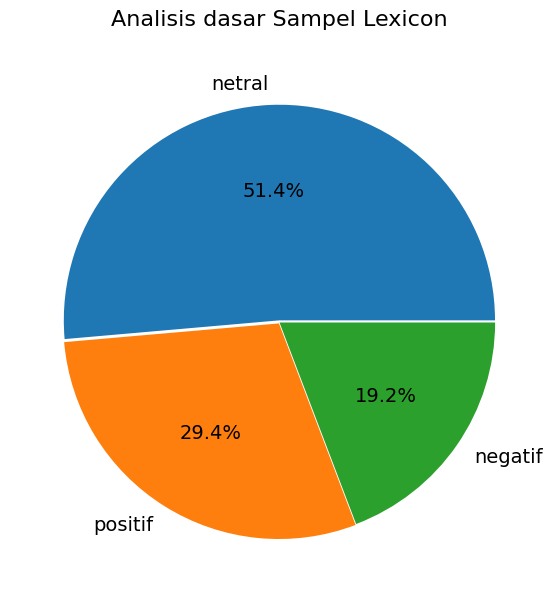

In [101]:
#Inspeksi Pie
fig, ax = plt.subplots(figsize=(7, 7))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in selp]

#pelabelan
labels = list(selp.index)

# Jarak
explode = (0.01, 0.005, 0)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Analisis dasar Sampel Lexicon', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

In [102]:
#teks sentimen positif: Pengambilan kolom polaritas
jpolaritas = dfkopitungk['polaritas'].copy()
makskol = 3000
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', makskol)

# Membuat DataFrame baru 'ulasanp' yang hanya berisi tweet dengan polaritas netral.
ulasanp = dfkopitungk[dfkopitungk['polaritas'] == 'positif']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'ulasanz'.
cuitanp = ulasanp[['final', 'nilai_polaritas', 'polaritas','stopword']].copy()

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
cuitanp = cuitanp.sort_values(by='nilai_polaritas', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
cuitanp = cuitanp.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
cuitanp.index += 1


In [103]:
#sentimen netral: Pengambilan kolom polaritas
jpolaritas = dfkopitungk['polaritas'].copy()
makskol = 3000
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', makskol)

# Membuat DataFrame baru 'ulasanp' yang hanya berisi tweet dengan polaritas negatif.
ulasanz = dfkopitungk[dfkopitungk['polaritas'] == 'netral']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'ulasanp'.
cuitanz = ulasanz[['final', 'nilai_polaritas', 'polaritas','stopword']].copy()

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
cuitanz = cuitanz.sort_values(by='nilai_polaritas', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
cuitanz = cuitanz.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
cuitanz.index += 1


In [104]:
#teks sentimen negatif: Pengambilan kolom polaritas
jpolaritas = dfkopitungk['polaritas'].copy()
makskol = 3000
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', makskol)

# Membuat DataFrame baru 'ulasanp' yang hanya berisi cuitan dengan polaritas positif.
ulasann = dfkopitungk[dfkopitungk['polaritas'] == 'negatif']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'ulasanp'.
cuitann = ulasann[['final', 'nilai_polaritas', 'polaritas','stopword']].copy()

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
cuitann = cuitann.sort_values(by='nilai_polaritas', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
cuitann = cuitann.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
cuitann.index += 1


#### Visualisasi kata-kata

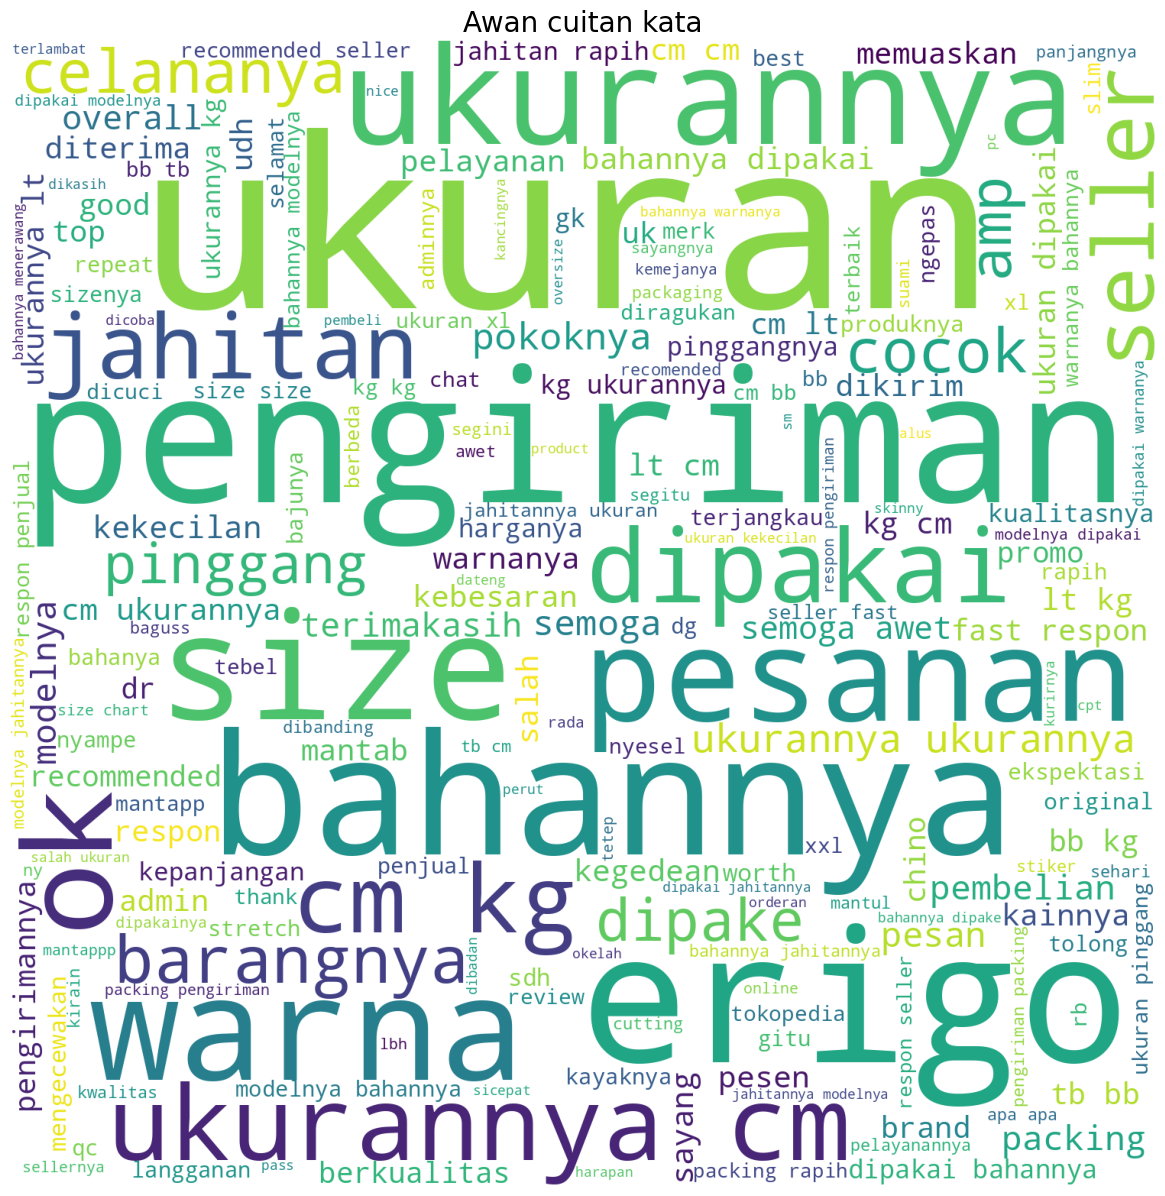

In [105]:
#sentimen di stopword
daftar_kata = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'clean_df'.
for tweet in dfkopitungk['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        daftar_kata += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=1500, height=1500, background_color='white', min_font_size=8).generate(daftar_kata)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(12, 12))

# Menetapkan judul untuk word cloud.
ax.set_title('Awan cuitan kata', fontsize=20)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

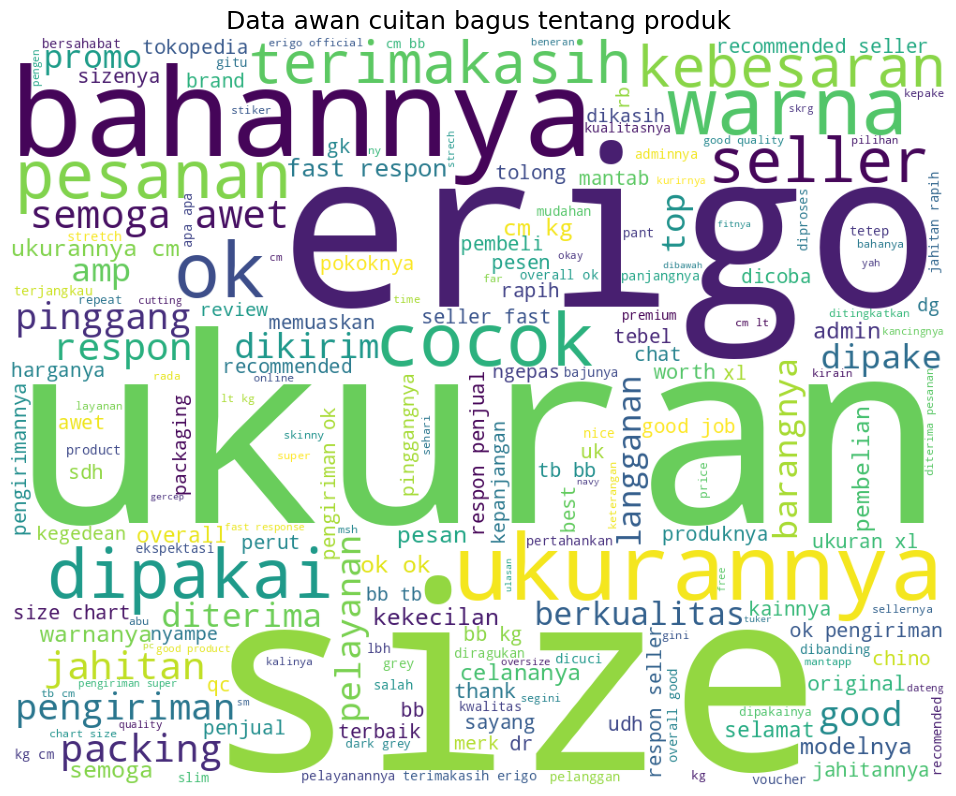

In [106]:
#Cuitan positif
positif = ''

# Iterasi melalui setiap tweet dalam kolom stopword di cuitann.
for tweet in cuitanp['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        positif += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=1000, height=800, background_color='white', min_font_size=10).generate(positif)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(10, 8))

# Menetapkan judul untuk word cloud.
ax.set_title('Data awan cuitan bagus tentang produk', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

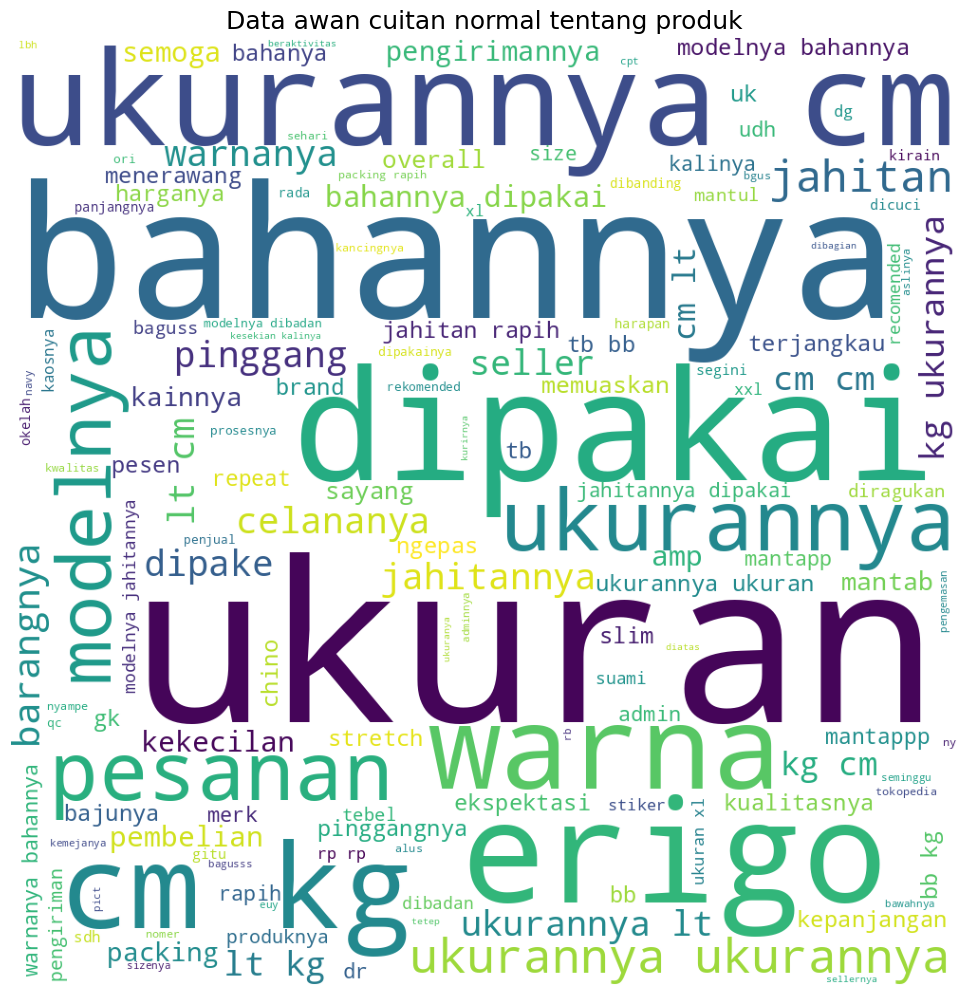

In [107]:
#Cuitan netral
normal = ''

# Iterasi melalui setiap tweet dalam kolom stopword di cuitann.
for tweet in cuitanz['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        normal += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=1000, height=1000, background_color='white', min_font_size=10).generate(normal)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(10, 10))

# Menetapkan judul untuk word cloud.
ax.set_title('Data awan cuitan normal tentang produk', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

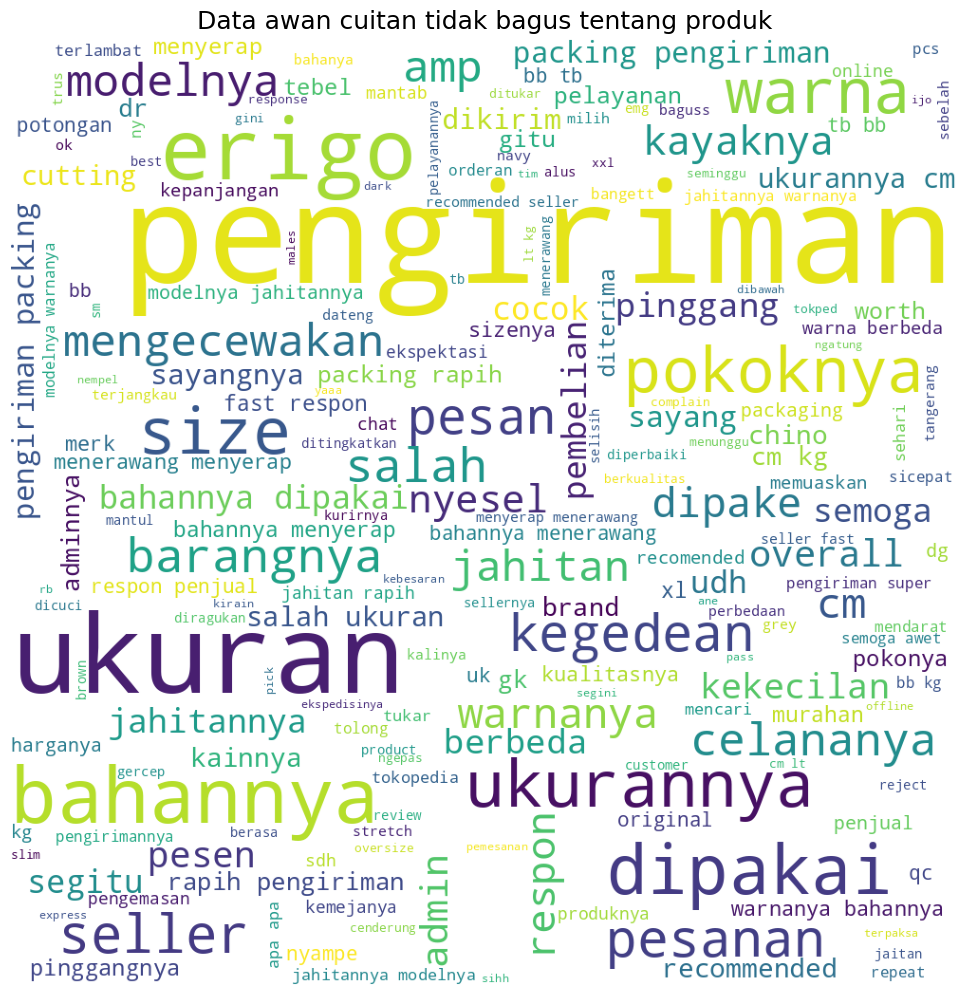

In [108]:
#Cuitan negatif
negatif = ''

# Iterasi melalui setiap tweet dalam kolom stopword di cuitann.
for tweet in cuitann['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        negatif += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=1000, height=1000, background_color='white', min_font_size=10).generate(negatif)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(10, 10))

# Menetapkan judul untuk word cloud.
ax.set_title('Data awan cuitan tidak bagus tentang produk', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

#### Grafik Batang

In [109]:
#cek kolom
dfkopitungk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8014 entries, 0 to 9581
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pesan            8014 non-null   object 
 1   Nilai            8014 non-null   int64  
 2   Label            8014 non-null   object 
 3   bersih           8014 non-null   object 
 4   kecil            8014 non-null   object 
 5   sopan            8014 non-null   object 
 6   token            8014 non-null   object 
 7   stopword         8014 non-null   object 
 8   final            8014 non-null   object 
 9   nilai_polaritas  8014 non-null   float64
 10  polaritas        8014 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 751.3+ KB


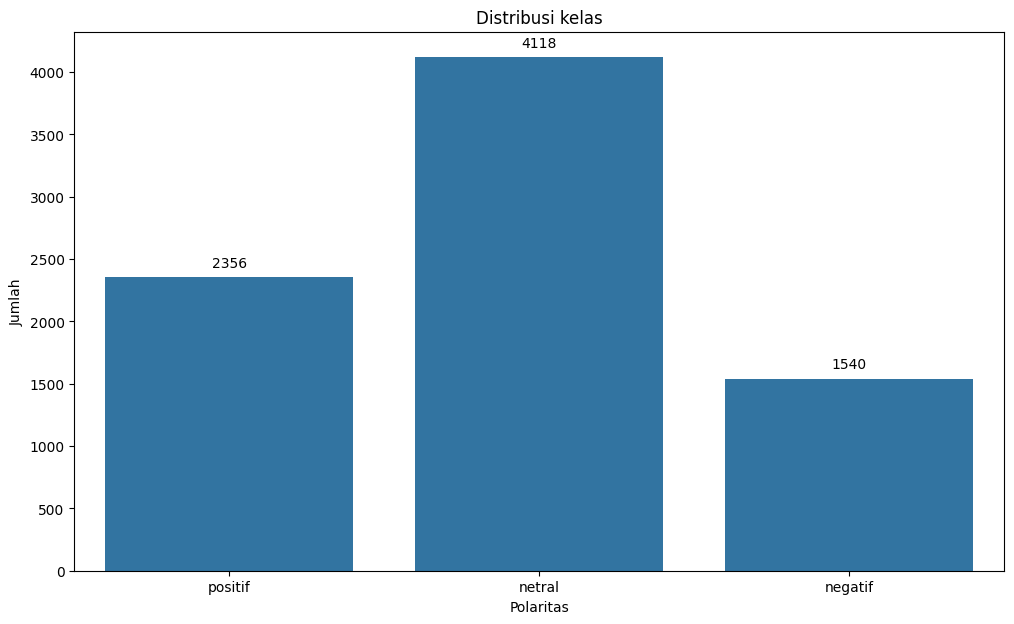

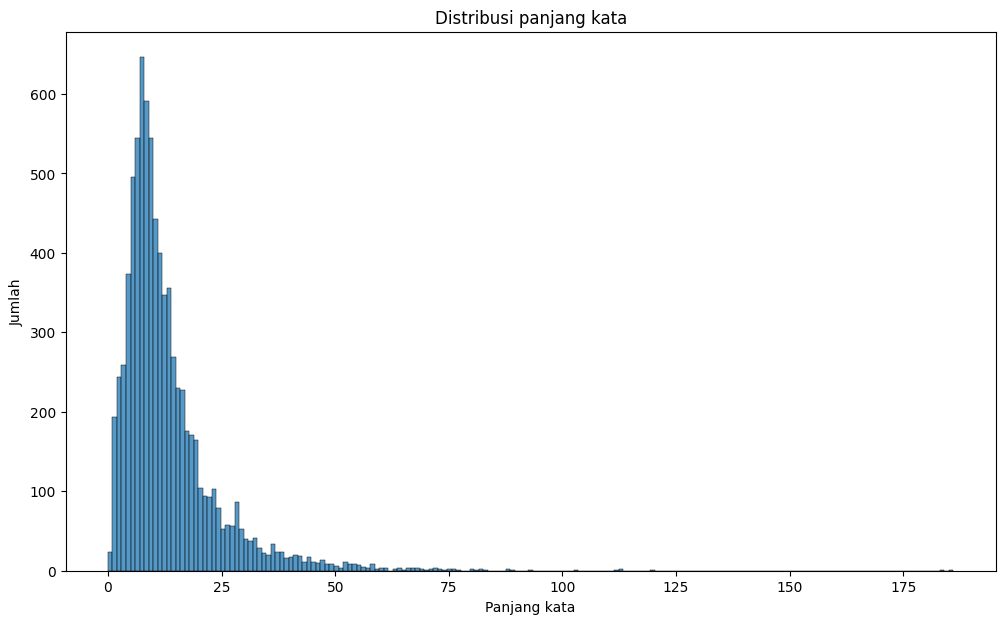

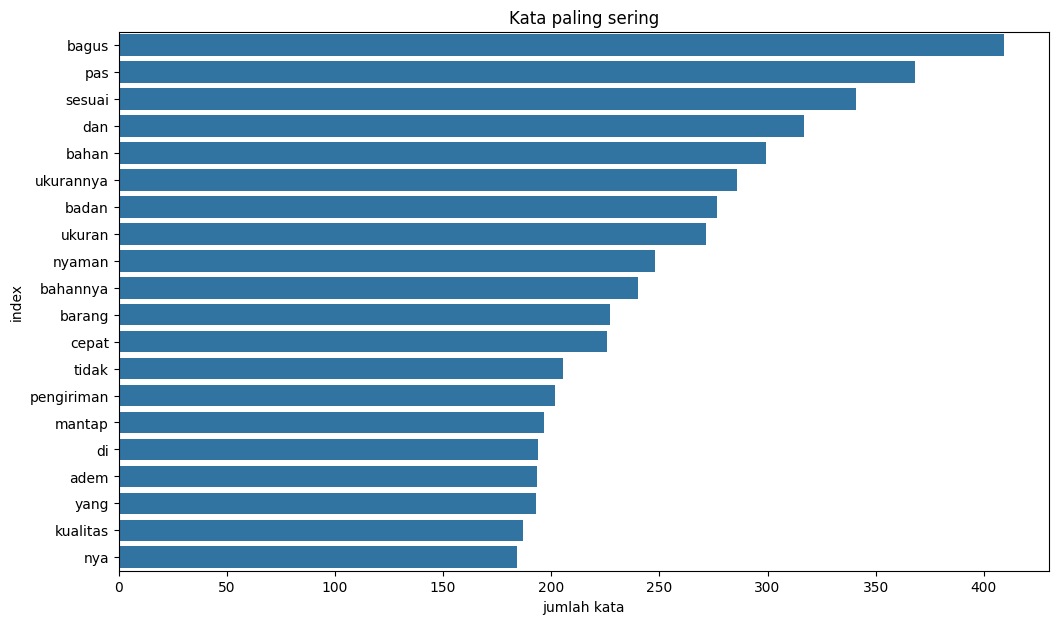

In [110]:
#Grafik batang
# Set the figure size
plt.figure(figsize=(12, 7))

# Check class distribution
class_dist_plot = sns.countplot(x='polaritas', data=dfkopitungk)
plt.title('Distribusi kelas')
plt.xlabel('Polaritas')
plt.ylabel('Jumlah')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

# Set the figure size
plt.figure(figsize=(12, 7))

# Visualize text length distribution
dfkopitungk['panjang_kata'] = dfkopitungk['final'].apply(lambda x: len(x.split()))
sns.histplot(dfkopitungk['panjang_kata'])
plt.title('Distribusi panjang kata')
plt.xlabel('Panjang kata')
plt.ylabel('Jumlah')
plt.show()

# Set the figure size
plt.figure(figsize=(12, 7))

# Inspeksi kata paling sering
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dfkopitungk['final'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah kata')
tfidf_df = tfidf_df.sort_values('jumlah kata', ascending=False).head(20)
sns.barplot(x='jumlah kata', y='index', data=tfidf_df)
plt.title('Kata paling sering')
plt.show()

#Eksekusi model
Prosedur yang digunakan
1. Teknik RFC ('Random Forest Classifier') dengan vektorisasi TFID
2. Teknik Support Vector dengan vektorisasi 'S-BERT'

## Persiapan model

In [111]:
#Pemisahan data
Xst = dfkopitungk['final'].copy() #cuitan
yst = dfkopitungk['polaritas'].copy() #pelabelan

In [112]:
#pembuatan df model
dfmodmen = pd.DataFrame({'Cuitan': Xst, 'Pelabelan': yst})
dfmodmen.head(7)

,Cuitan,Pelabelan
0,barang bagus kualitas nya top harga nya naik overall dijamin ori,positif
1,modelnya keren bahannya bagus cuma agak kepanjangan perlu dipermak dikit,netral
2,tinggi bb ukuran l cocok si pas dan enak banget bahannya adem murah lagi,positif
3,enak di pakai adem dan kece pas di badan saya tapi kayaknya mudah lecek nyaman dipakai modelnya keren jahitannya rapi ukuran sesuai warnanya mantap bahannya adem kancing tidak mudah lepas produk sesuai dengan foto kualitas produk bagus,negatif
4,apa ini woy keren banget kemeja nya tidak usa ragu kualitas erigo ganteng banget sumpah kemeja nya tidak kaku tapi juga tidak kerut bahan adem lembut halus gmn yah seperti tidak ingin di lepas kalau pakai ini kemeja sukses terus erigo pertahankan iya kualitas barang udh ganteng banget ini mah harga setara rb ydh itu saja review nya,positif
5,oke paket di terima dengan baik untuk kualitas barang oke kok kak bagus tapi sayang nya untuk pengiriman agak lama kak oke itu saja dari saya,negatif
6,pas bahannya enak banget dibadan dan juga keren tidak heran sih karena ini dari erigo mantap deh,netral


In [113]:
#pelabelan dengan vektorisasi
tfidfv = TfidfVectorizer(max_features=400, min_df=17, max_df=0.8)
X_tfidf = tfidfv.fit_transform(Xst)
#pembuatan barisan [array]
Xtdifar = X_tfidf.toarray()
#pembuatan kolom
Xcolumns = tfidfv.get_feature_names_out()

In [ ]:
#vektorisasi dengan 'Fast Text'
lenco = LabelEncoder()
ysten = lenco.fit_transform(yst)

In [ ]:
#eksekusi dengan fast text: Tokenisasi
tokenisasi = [tweet.split() for tweet in Xst]

# Train FastText model
fasttext_model = FastText(sentences=tokenisasi, vector_size=100, window=3, min_count=1, workers=4)

# Create feature vectors for each tweet
X_fst = []
for tweet in tokenisasi:
    # Get vectors for words present in the model's vocabulary
    word_vectors = [fasttext_model.wv[word] for word in tweet if word in fasttext_model.wv]

    # If any word vectors are found, calculate the average, otherwise create a zero vector
    if word_vectors:
        vector = np.mean(word_vectors, axis=0)  # Calculate average of word vectors
    else:
        vector = np.zeros(fasttext_model.vector_size)  # Create zero vector

    X_fst.append(vector)

X_fasttext = np.array(X_fst)

### Persiapan pelatihan

In [131]:
#pemisahan data menjadi sampel dan latihan
X_train, X_test, y_train, y_test = train_test_split(Xtdifar, yst, test_size=0.222, random_state=40, stratify=yst)

In [ ]:
#penyatuan kembail ke df untuk SVM
X_trains, X_tests, y_trains, y_tests = train_test_split(X_fasttext, ysten, test_size=0.255, random_state=40, stratify=ysten)

In [ ]:
#persiapan data latihan


Tanda **'S'** menyatakann SVM

In [132]:
#Modifikais SMOTE
smote = SMOTE(random_state=40)
X_train2, y_train2 = smote.fit_resample(X_train, y_train)

In [133]:
#pemasangan berat sampel
brtsampllat = csw(class_weight='balanced', y=y_train) #menyeimbangkan berat di latihan
brtsampllatsmo = csw(class_weight='balanced', y=y_train2) #menyeimbangkan berat di pengujian pasca SMOTE
#ke tes

In [134]:
#di sumbu tes
brtsamptes = csw(class_weight='balanced', y=y_test) #menyeimbangkan berat di pengujian

In [ ]:
#berat sampel di SVM
brtsampllatsv = csw(class_weight='balanced', y=y_trains) #menyeimbangkan berat di latihan untuk SVM
brtsamptessv = csw(class_weight='balanced', y=y_tests) #menyeimbangkan berat di pengujian untuk SVM

## Deklarasi Kamus Berat

In [135]:
#pemasangan berat data melalui Persiapan kamus berat sampel
klsbrt = np.unique(y_train) #kelas berat di RFC normal
dictbrt = dict(zip(klsbrt, brtsampllat)) #dideklarasikan sebagai kampus [normal]

In [136]:
#Kondisi SMOTE
klsbrts = np.unique(y_train2) #kelas berat di RFC pasca SMOTE
dictbrts = dict(zip(klsbrts, brtsampllatsmo)) #dideklarasikan sebagai kampus [pasca SMOTE]

In [ ]:
#kondisi SVM
klsbrtsvm = np.unique(y_trains) #kelas berat di SVM normal
dictbrtsvm = dict(zip(klsbrtsvm, brtsampllatsv)) #dideklarasikan sebagai kampus [normal]

### Tanpa pelacakan nilai ccp

In [156]:
#eksekusi normal
randford = rfclasifi(n_estimators=108,max_depth=24,ccp_alpha=4.5e-5,min_samples_split=4,min_samples_leaf=6,
    max_leaf_nodes=24,class_weight=dictbrt,random_state=40,warm_start = True, oob_score=True, verbose=1) #normal
#ke eksekusi tanpa fungsi

In [ ]:
#eksekusi dengan SMOTE
randfordsmo = rfclasifi(n_estimators=108,max_depth=20,ccp_alpha=7.75e-4,max_leaf_nodes=20,min_samples_split=5,min_samples_leaf=5,
                        class_weight=dictbrts,random_state=39,warm_start = True, oob_score=True) #pakai SMOTE
#ke eksekusi fungsi

In [157]:
#implementasi 'validasi silang'
scores = cross_val_score(randford, X_train, y_train, cv=6)
#pembulatan
rounded = np.round(scores,3)
#percetakan
print(rounded)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s


[0.815 0.828 0.814 0.806 0.813 0.805]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [158]:
#eksekusi tanpa inspeksi
randford.fit(X_train, y_train, sample_weight=brtsampllat)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s


RandomForestClassifier(ccp_alpha=4.5e-05,
                       class_weight={'negatif': 0.6487667811426787,
                                     'netral': 0.6487667811426787,
                                     'positif': 0.6487667811426787},
                       max_depth=24, max_leaf_nodes=24, min_samples_leaf=6,
                       min_samples_split=4, n_estimators=108, oob_score=True,
                       random_state=40, verbose=1, warm_start=True)

In [159]:
#Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = randford.predict(X_train)
y_pred_test_rf = randford.predict(X_test)

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train, sample_weight=brtsampllat)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test, sample_weight=brtsamptes)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [160]:
# Menghitung precision, recall, dan F1 score untuk data uji
precision_test_rf = precision_score(y_test, y_pred_test_rf, average='weighted', zero_division =0, sample_weight = brtsamptes)
recall_test_rf = recall_score(y_test, y_pred_test_rf, average='weighted', zero_division =0, sample_weight = brtsamptes)
f1_test_rf = f1_score(y_test, y_pred_test_rf, average='weighted', zero_division =0, sample_weight = brtsamptes)

# Pembulatan nilai untuk kemudahan
rounded_accuracy_train = round(accuracy_train_rf, 3)
rounded_accuracy_test = round(accuracy_test_rf, 3)
rounded_precision = round(precision_test_rf, 3)
rounded_recall = round(recall_test_rf, 3)
rounded_f1 = round(f1_test_rf, 3)

# Menampilkan hasil evaluasi
print('Nilai Akurasi di latihan dengan RFC:', rounded_accuracy_train)
print('Nilai Akurasi di tes dengan RFC:', rounded_accuracy_test)
print('Nilai Presisi di RFC:', rounded_precision)
print('Nilai panggilan balik di RFC:', rounded_recall)
print('Inspeksi nilai F1 di RFC:', rounded_f1)

Nilai Akurasi di latihan dengan RFC: 0.812
Nilai Akurasi di tes dengan RFC: 0.79
Nilai Presisi di RFC: 0.804
Nilai panggilan balik di RFC: 0.79
Inspeksi nilai F1 di RFC: 0.788


In [ ]:
#deklarasi dengan grid
param_grid = {'n_estimators': [100, 150],'max_features': ['auto', 'sqrt', 2],'max_depth': [3, 6, 9, 12],'min_samples_split': [2, 4, 5, 8, 10],'min_samples_leaf': [1, 2, 4, 5],"criterion": ["gini", "entropy"],"oob_score": [True, False]}

## Pendukungan Vektor

In [ ]:
#tahap awal
dtrain = xgb.DMatrix(X_trains, label=y_trains)
dtest = xgb.DMatrix(X_tests)
#parameter
paramet  = {
    'objective': 'multi:softmax',  # Spesifikasikan
    'num_class': len(np.unique(y_trains)),  # Number of classes
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'mlogloss'
}


In [ ]:
#latihan
bst = xgb.train(paramet, dtrain, num_boost_round=100)

In [ ]:
#hasil terbaik
y_pred_train_xgb = bst.predict(dtrain)
y_pred_test_xgb = bst.predict(dtest)
#cetak hasil untuk Evaluasi dan Latihan
accuracy_train_xgb = accuracy_score(y_trains, y_pred_train_xgb)
accuracy_test_xgb = accuracy_score(y_tests, y_pred_test_xgb)

precision_test_xgb = precision_score(y_tests, y_pred_test_xgb, average='weighted', zero_division=0)
recall_test_xgb = recall_score(y_tests, y_pred_test_xgb, average='weighted', zero_division=0)
f1_test_xgb = f1_score(y_tests, y_pred_test_xgb, average='weighted', zero_division=0)

# Display results
print(f'Akurasi Latihan : {accuracy_train_xgb:.3f}')
print(f'Akurasi Tes: {accuracy_test_xgb:.3f}')
print(f'Presisi : {precision_test_xgb:.3f}')
print(f'Pangilan ulang: {recall_test_xgb:.3f}')
print(f'Nilai F1: {f1_test_xgb:.3f}')

Akurasi Latihan : 0.935
Akurasi Tes: 0.569
Presisi : 0.558
Pangilan ulang: 0.569
Nilai F1: 0.559


## Tahap Regresi Logistik

In [ ]:
#tahap 1


In [ ]:
#tahap lanjutan


In [ ]:
#Eksekusi
